In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Political parties analysis

This document is aimed to explain oriention of the Europian political parties towards EU leadership based on 2019 Chapel Hill Expert Survey. The data contains info about positioning of 277 political parties from Europe and Turkey on political ideology, European integration, and policy positions. It's a quite a detailed survey, so there are many features, explanatory variables, what makes this data set high dimensional. Dimension represents feature, variable, parameter. More variables the data set has, higher the dimension is. 
However working with high dimensional data sets is not very feasible, so it's better to reduce the dimensions (number of features), without loosing too much information and keeping the performance of the model.
There are many different approaches (like PCA, Principle Component Analysis) and ready python packages for dimensionality reduction. I choose for the following approach (because it's easy interpretable and accurate):

    1.  Read the data set.
    2.  Check the percentage of NaNs per column.
    2.  Remove the columns with high percentage of NaNs (in our case there were three columns with more than 98% missing values).
    3.  Fill the rest of the NaNs with the median values of corresponding columns.
    4.  Check the variance of the variables. Variables with small variance are almost contstant and don't affect the target variabble. 
    5.  Check the correlation between the variables. Highly correlated variables contain the same info, so we can safelly remove some of them. 
    6.1 Estimate the feature importance with Random Forest and select the most important feature.
    6.2 Make linear regression model with single variable (for all features in the data set run a separate regression) and compare the R2 (goodness of the fit). Select the feature with the highest R2 (the best fit, most of the variance explained)
        Variable with the highest R2 explains the most of the variance.
    7.  Visualize the results
    8.  Generate new data points from the fitted distribution
    9.  For the new political parties, find feature values from the high-dimensional space that map to the sampled 2D points.

6.1 and 6.2 are alternative to one other. Just for an overwiev both methods are presented. 
Basically we want to describe the attitude of Europian parties toward EU leadership with only two variables.
"eu_position" = overall orientation of the party leadership towards European integration in 2019 is taken as a target or dependant variable. For the sake of clarity "eastwest" is considered as a dummy variable with two separate classes "east" and "west". Further in the analysis we'll give a small example and explain why this segmentation could be usefull. 

In [2]:
### if not installed
#! pip install plotnine

In [3]:
import functions
import imp
imp.reload(functions)
from functions import *

In [4]:
data = pd.read_csv("CHES2019V3.csv")

In [5]:
data.shape

(277, 55)

In [6]:
pd.set_option("display.max_columns", None)

#### Since we consider east and west as two separate classes, check if we have missing values. We fill missing values with unknown. They belong to the countries like Turkey, Switzerland, Norway and Iceland that are not a part of EU. However some other variables are also missing for these parties. They will be filled with the median of the corresponding columns. They all will have same, constant value. 

In [7]:
data[data['eastwest'].isnull()]

,country,eastwest,party,party_id,eu_position,eu_position_sd,eu_salience,eu_dissent,eu_blur,eu_cohesion,eu_foreign,eu_intmark,eu_budgets,eu_asylum,lrgen,lrecon,lrecon_sd,lrecon_salience,lrecon_dissent,lrecon_blur,galtan,galtan_sd,galtan_salience,galtan_dissent,galtan_blur,immigrate_policy,immigrate_salience,immigrate_dissent,multiculturalism,multicult_salience,multicult_dissent,redistribution,redist_salience,environment,enviro_salience,spendvtax,deregulation,econ_interven,civlib_laworder,sociallifestyle,religious_principles,ethnic_minorities,nationalism,urban_rural,protectionism,regions,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership,eu_econ_require,eu_political_require,eu_googov_require
230,34,NaN,AKP,3401,3.777778,1.986063,3.111111,2.000000,6.600000,NaN,NaN,NaN,NaN,NaN,8.000000,6.777778,1.563472,8.666667,2.800000,4.250000,9.444445,0.726483,8.222222,1.200000,2.500000,5.000000,7.500000,4.125000,6.375000,7.500000,4.000000,6.500000,4.125000,9.000000,1.666667,4.000000,6.750000,4.222222,9.444445,9.444445,9.666667,8.777778,9.333333,5.875000,3.625000,9.333333,3.600000,NaN,4.125000,7.750000,0.375000,9.777778,5.000000,1.625000,1.857143
231,34,NaN,CHP,3402,6.111111,0.600925,4.222222,3.250000,2.750000,NaN,NaN,NaN,NaN,NaN,3.666667,4.000000,0.866025,8.555555,3.400000,2.500000,3.444444,1.589899,7.333334,3.200000,4.250000,8.125000,8.250000,4.250000,6.375000,7.875000,3.000000,2.750000,7.500000,3.111111,6.888889,2.142857,3.500000,4.111111,2.555556,2.666667,1.000000,4.750000,3.444444,2.875000,5.250000,5.111111,4.000000,NaN,4.000000,4.250000,8.875000,6.111111,5.875000,5.888889,6.250000
232,34,NaN,MHP,3403,2.222222,0.833333,2.666667,0.250000,1.750000,NaN,NaN,NaN,NaN,NaN,9.333333,7.000000,2.329930,4.875000,1.800000,5.666666,9.444445,0.881917,6.875000,0.200000,1.000000,8.125000,8.250000,1.625000,9.250000,8.500000,0.833333,6.375000,3.142857,7.888889,0.625000,4.142857,5.000000,4.250000,9.555555,9.777778,8.000000,10.000000,10.000000,6.000000,6.000000,10.000000,4.600000,NaN,3.125000,5.428571,0.500000,9.750000,3.000000,1.250000,1.857143
233,34,NaN,HDP,3407,6.333334,0.707107,4.333334,2.500000,0.500000,NaN,NaN,NaN,NaN,NaN,1.666667,1.875000,0.353553,6.444445,2.750000,3.000000,1.333333,0.866025,8.222222,1.200000,1.750000,3.142857,5.571429,2.200000,2.750000,4.571429,1.400000,0.750000,8.250000,1.000000,7.555555,1.666667,2.142857,3.375000,0.333333,1.000000,0.444444,0.000000,0.888889,5.125000,6.142857,0.000000,2.600000,NaN,5.750000,6.125000,8.875000,4.125000,5.571429,7.000000,6.750000
234,34,NaN,IYI,3408,5.000000,1.000000,2.666667,2.000000,4.250000,NaN,NaN,NaN,NaN,NaN,7.111111,5.875000,1.457738,7.875000,4.750000,4.000000,5.625000,1.060660,6.875000,3.600000,3.333333,8.250000,8.000000,2.500000,8.750000,8.000000,2.250000,4.000000,6.000000,4.500000,4.625000,4.142857,4.571429,5.000000,5.000000,6.375000,5.000000,6.777778,7.888889,4.428571,5.714286,8.625000,5.000000,NaN,3.875000,4.714286,8.125000,8.111111,5.000000,4.555555,5.375000
235,35,NaN,Ap,3501,5.400000,0.516398,3.800000,5.500000,6.500000,NaN,NaN,NaN,NaN,NaN,3.400000,3.400000,0.516398,7.400000,3.000000,4.333334,3.200000,0.918937,4.333334,6.750000,4.000000,5.100000,4.500000,6.750000,4.111111,4.600000,5.777778,2.600000,7.200000,5.300000,4.500000,2.400000,3.666667,3.000000,4.900000,2.200000,3.300000,3.666667,4.100000,4.200000,5.333334,5.333334,1.666667,1.900000,2.555556,1.400000,1.777778,6.142857,NaN,NaN,NaN
236,35,NaN,FrP,3502,3.100000,1.791957,3.600000,4.250000,3.750000,NaN,NaN,NaN,NaN,NaN,8.400000,7.900000,1.100505,4.400000,6.000000,4.833334,6.800000,1.813529,7.000000,3.000000,2.666667,9.700000,8.900000,1.500000,9.400000,9.600000,3.000000,6.400000,5.800000,8.700000,3.700000,8.600000,8.666667,7.000000,8.300000,5.700000,5.500000,9.333333,8.800000,5.000000,4.444445,6.222222,1.222222,8.500000,6.555555,7.700000,2.000000,7.000000,NaN,NaN,NaN
237,35,NaN,H,3503,6.300000,0.674949,4.100000,2.000000,3.250000,NaN,NaN,NaN,NaN,NaN,6.700000,7.300000,0.948683,7.

In [8]:
data = functions.eastwest(data)

In [9]:
data.eastwest.unique()

array(['east', 'west', 'unknown'], dtype=object)

#### 1. Check the percentage of NaNs per column.

In [10]:
functions.check_na(data)

country                   0.000000
eastwest                  0.000000
party                     0.361011
party_id                  0.000000
eu_position               0.000000
eu_position_sd            0.000000
eu_salience               0.000000
eu_dissent                0.722022
eu_blur                   0.361011
eu_cohesion              10.830325
eu_foreign               11.191336
eu_intmark               10.830325
eu_budgets               11.191336
eu_asylum                11.191336
lrgen                     0.000000
lrecon                    0.000000
lrecon_sd                 0.000000
lrecon_salience           0.000000
lrecon_dissent            0.722022
lrecon_blur               1.083032
galtan                    0.000000
galtan_sd                 0.000000
galtan_salience           0.000000
galtan_dissent            2.888087
galtan_blur               0.722022
immigrate_policy          0.000000
immigrate_salience        0.000000
immigrate_dissent         0.361011
multiculturalism    

#### 2.  Remove the columns with high percentage of NaNs

In [11]:
data = functions.remove_variables(data, ['eu_econ_require','eu_political_require','eu_googov_require'])

#### 3.  Fill the rest of the NaNs with the median values of corresponding columns.

In [12]:
data = functions.fillna(data)

In [13]:
data[data['eastwest']== 'unknown']  #### constant values for some variables like eu_cohesion, eu_foreign, eu_intmark, eu_budgets, eu_asylum

,country,eastwest,party,party_id,eu_position,eu_position_sd,eu_salience,eu_dissent,eu_blur,eu_cohesion,eu_foreign,eu_intmark,eu_budgets,eu_asylum,lrgen,lrecon,lrecon_sd,lrecon_salience,lrecon_dissent,lrecon_blur,galtan,galtan_sd,galtan_salience,galtan_dissent,galtan_blur,immigrate_policy,immigrate_salience,immigrate_dissent,multiculturalism,multicult_salience,multicult_dissent,redistribution,redist_salience,environment,enviro_salience,spendvtax,deregulation,econ_interven,civlib_laworder,sociallifestyle,religious_principles,ethnic_minorities,nationalism,urban_rural,protectionism,regions,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership
230,34,unknown,AKP,3401,3.777778,1.986063,3.111111,2.000000,6.600000,5.785714,4.279221,5.454546,3.944444,4.183333,8.000000,6.777778,1.563472,8.666667,2.800000,4.250000,9.444445,0.726483,8.222222,1.200000,2.500000,5.000000,7.500000,4.125000,6.375000,7.500000,4.000000,6.500000,4.125000,9.000000,1.666667,4.000000,6.750000,4.222222,9.444445,9.444445,9.666667,8.777778,9.333333,5.875000,3.625000,9.333333,3.600000,2.111111,4.125000,7.750000,0.375000,9.777778
231,34,unknown,CHP,3402,6.111111,0.600925,4.222222,3.250000,2.750000,5.785714,4.279221,5.454546,3.944444,4.183333,3.666667,4.000000,0.866025,8.555555,3.400000,2.500000,3.444444,1.589899,7.333334,3.200000,4.250000,8.125000,8.250000,4.250000,6.375000,7.875000,3.000000,2.750000,7.500000,3.111111,6.888889,2.142857,3.500000,4.111111,2.555556,2.666667,1.000000,4.750000,3.444444,2.875000,5.250000,5.111111,4.000000,2.111111,4.000000,4.250000,8.875000,6.111111
232,34,unknown,MHP,3403,2.222222,0.833333,2.666667,0.250000,1.750000,5.785714,4.279221,5.454546,3.944444,4.183333,9.333333,7.000000,2.329930,4.875000,1.800000,5.666666,9.444445,0.881917,6.875000,0.200000,1.000000,8.125000,8.250000,1.625000,9.250000,8.500000,0.833333,6.375000,3.142857,7.888889,0.625000,4.142857,5.000000,4.250000,9.555555,9.777778,8.000000,10.000000,10.000000,6.000000,6.000000,10.000000,4.600000,2.111111,3.125000,5.428571,0.500000,9.750000
233,34,unknown,HDP,3407,6.333334,0.707107,4.333334,2.500000,0.500000,5.785714,4.279221,5.454546,3.944444,4.183333,1.666667,1.875000,0.353553,6.444445,2.750000,3.000000,1.333333,0.866025,8.222222,1.200000,1.750000,3.142857,5.571429,2.200000,2.750000,4.571429,1.400000,0.750000,8.250000,1.000000,7.555555,1.666667,2.142857,3.375000,0.333333,1.000000,0.444444,0.000000,0.888889,5.125000,6.142857,0.000000,2.600000,2.111111,5.750000,6.125000,8.875000,4.125000
234,34,unknown,IYI,3408,5.000000,1.000000,2.666667,2.000000,4.250000,5.785714,4.279221,5.454546,3.944444,4.183333,7.111111,5.875000,1.457738,7.875000,4.750000,4.000000,5.625000,1.060660,6.875000,3.600000,3.333333,8.250000,8.000000,2.500000,8.750000,8.000000,2.250000,4.000000,6.000000,4.500000,4.625000,4.142857,4.571429,5.000000,5.000000,6.375000,5.000000,6.777778,7.888889,4.428571,5.714286,8.625000,5.000000,2.111111,3.875000,4.714286,8.125000,8.111111
235,35,unknown,Ap,3501,5.400000,0.516398,3.800000,5.500000,6.500000,5.785714,4.279221,5.454546,3.944444,4.183333,3.400000,3.400000,0.516398,7.400000,3.000000,4.333334,3.200000,0.918937,4.333334,6.750000,4.000000,5.100000,4.500000,6.750000,4.111111,4.600000,5.777778,2.600000,7.200000,5.300000,4.500000,2.400000,3.666667,3.000000,4.900000,2.200000,3.300000,3.666667,4.100000,4.200000,5.333334,5.333334,1.666667,1.900000,2.555556,1.400000,1.777778,6.142857
236,35,unknown,FrP,3502,3.100000,1.791957,3.600000,4.250000,3.750000,5.785714,4.279221,5.454546,3.944444,4.183333,8.400000,7.900000,1.100505,4.400000,6.000000,4.833334,6.800000,1.813529,7.000000,3.000000,2.666667,9.700000,8.900000,1.500000,9.400000,9.600000,3.000000,6.400000,5.800000,8.700000,3.700000,8.600000,8.666667,7.000000,8.300000,5.700000,5.500000,9.333333,8.800000,5.000000,4.444445,6.222222,1.222222,8.500000,6.555555,7.700000,2.000000,7.000000
237,35,unknown,H,3503,6.300000,0.674949,4.100000,2.000000,3.250000,5.785714,4.279221,5.454546,3.94

In [14]:
data = data[data['eastwest']!='unknown'] ### remove these points

In [15]:
data_limited = functions.remove_variables(data,['country','party_id','party'])

### 4.  Check the variance of the variables.

In [16]:
functions.check_variance(data_limited) ### we remove variables with variance bellow 0.5

eu_position              2.760828
eu_position_sd           0.152011
eu_salience              2.363680
eu_dissent               1.896610
eu_blur                  3.134143
eu_cohesion              1.440687
eu_foreign               2.241838
eu_intmark               2.035397
eu_budgets               2.101797
eu_asylum                2.278455
lrgen                    5.576377
lrecon                   4.337508
lrecon_sd                0.349895
lrecon_salience          2.129672
lrecon_dissent           1.753606
lrecon_blur              2.590836
galtan                   7.114877
galtan_sd                0.408310
galtan_salience          2.110227
galtan_dissent           2.251951
galtan_blur              2.681731
immigrate_policy         6.728658
immigrate_salience       3.591817
immigrate_dissent        2.060791
multiculturalism         6.463877
multicult_salience       3.045488
multicult_dissent        1.640418
redistribution           3.995974
redist_salience          1.969963
environment   

In [17]:
data_limited = functions.remove_variables(data_limited,['galtan_sd','eu_position_sd','lrecon_sd'])

### Quick overview how the data are distributed per feature (just to get some insights)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

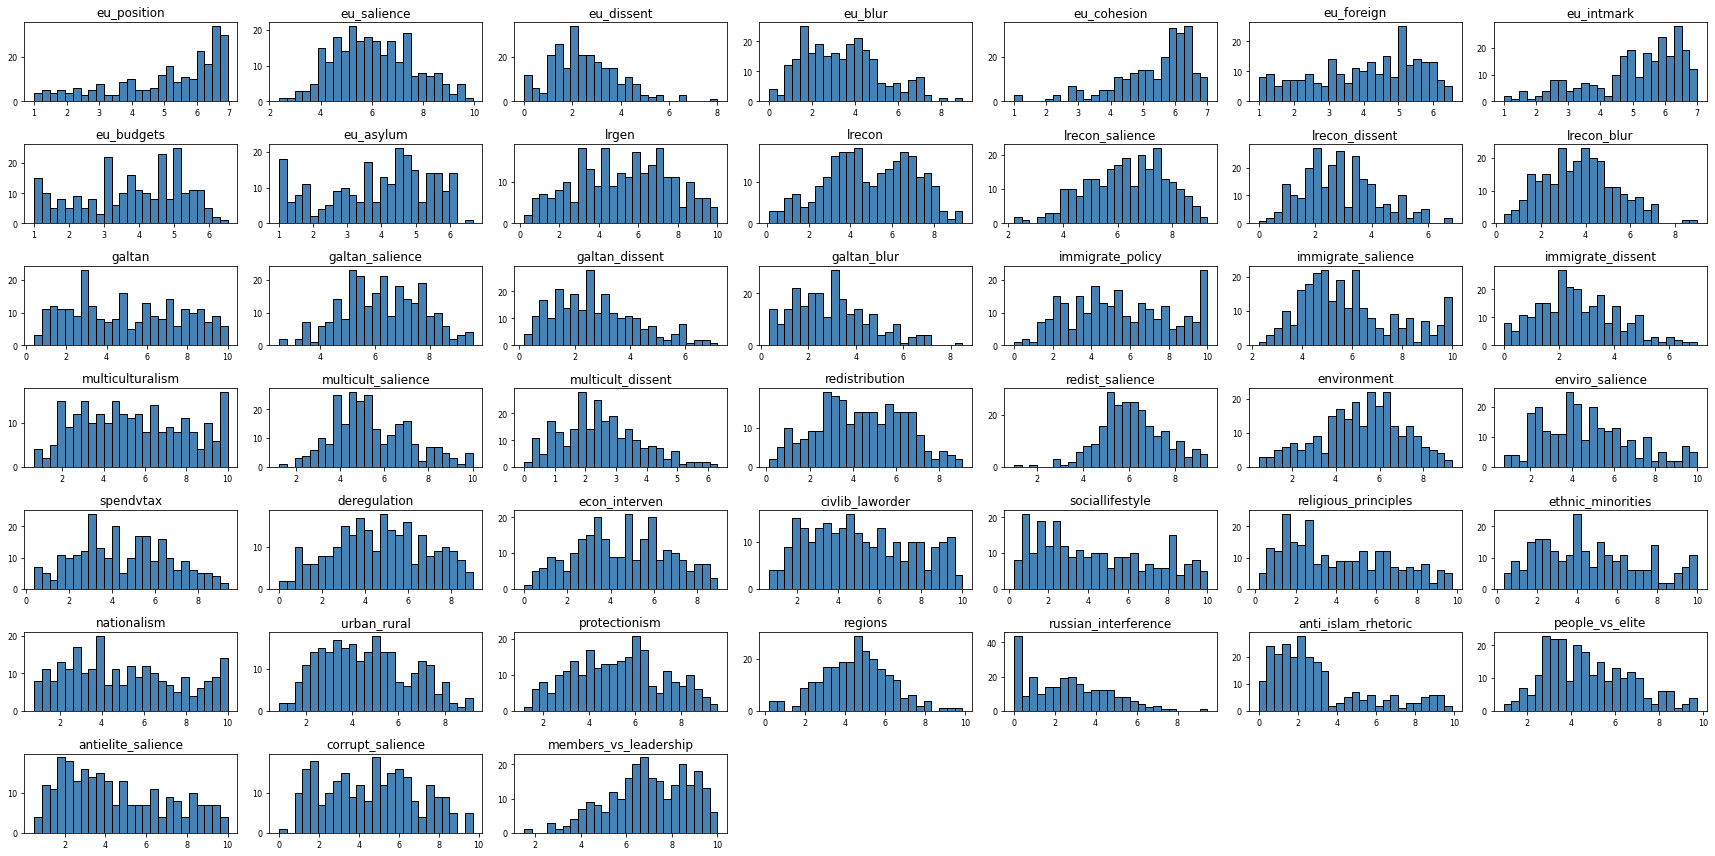

In [18]:
functions.distribution_plot(data_limited)

### Prepare the data for ML models

In [19]:
dependant_variable = data_limited[['eu_position']]
train_set = data_limited.drop('eu_position', axis = 1)

In [20]:
train_set

,eastwest,eu_salience,eu_dissent,eu_blur,eu_cohesion,eu_foreign,eu_intmark,eu_budgets,eu_asylum,lrgen,lrecon,lrecon_salience,lrecon_dissent,lrecon_blur,galtan,galtan_salience,galtan_dissent,galtan_blur,immigrate_policy,immigrate_salience,immigrate_dissent,multiculturalism,multicult_salience,multicult_dissent,redistribution,redist_salience,environment,enviro_salience,spendvtax,deregulation,econ_interven,civlib_laworder,sociallifestyle,religious_principles,ethnic_minorities,nationalism,urban_rural,protectionism,regions,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership
0,east,4.272728,2.75,2.166667,6.250,5.444445,4.777778,4.250,5.555555,2.083333,2.250000,8.166667,2.2,1.142857,2.916667,4.000000,2.5,2.750000,3.416667,4.250000,3.400000,3.083333,4.454546,3.5,1.583333,8.166667,4.500000,4.363637,2.000000,2.0,1.545454,3.090909,2.000000,1.5,2.636364,3.454546,3.333333,6.272728,6.000000,0.111111,2.111111,3.363636,2.181818,1.909091,7.500000
1,east,4.181818,2.50,1.714286,6.000,5.444445,4.777778,4.625,5.444445,3.083333,3.083333,7.916666,2.2,1.428572,2.750000,4.583334,2.5,2.777778,4.083334,4.500000,4.181818,3.333333,5.000000,3.8,2.000000,8.083333,4.272728,4.363637,2.666667,2.2,2.000000,3.666667,1.909091,1.6,2.454546,3.083333,3.000000,5.727272,5.333334,0.111111,2.222222,3.545454,2.090909,1.636364,6.818182
2,east,4.818182,2.50,1.428572,6.000,5.666666,4.777778,4.750,6.000000,2.083333,2.500000,6.250000,3.4,2.000000,1.083333,6.272728,1.0,1.625000,2.000000,6.000000,2.000000,1.750000,5.909091,2.7,1.916667,7.000000,0.916667,9.363636,2.166667,2.0,2.181818,2.000000,1.000000,1.9,2.000000,1.750000,1.800000,5.818182,6.166666,0.111111,2.888889,5.636363,2.454546,2.363636,3.909091
3,east,4.818182,2.50,1.285714,5.875,5.666666,4.777778,4.750,6.000000,2.416667,2.666667,6.250000,3.0,2.000000,1.166667,6.416666,1.0,1.666667,2.250000,5.583334,2.090909,1.916667,5.818182,2.7,2.250000,7.000000,0.833333,9.500000,2.333333,2.2,2.363636,2.083333,0.909091,1.8,2.000000,1.916667,1.900000,5.909091,6.083334,0.111111,2.777778,5.636363,2.363636,2.000000,4.000000
4,east,5.090909,2.00,1.714286,5.500,5.777778,6.000000,5.500,5.666666,6.500000,6.916666,8.083333,2.4,1.285714,3.181818,4.454546,1.5,3.125000,5.583334,4.666666,4.600000,4.916666,4.181818,4.5,5.833334,6.000000,6.272728,3.818182,6.583334,6.9,6.636363,4.727272,2.727273,1.8,4.454546,3.333333,4.444445,2.727273,6.416666,0.111111,2.333333,4.636363,1.727273,1.636364,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,east,6.500000,1.00,5.000000,7.000,3.000000,5.000000,4.000,4.000000,4.500000,4.500000,5.500000,3.0,7.000000,6.000000,3.500000,2.5,6.500000,7.000000,6.000000,3.500000,6.500000,4.000000,3.0,4.000000,6.000000,6.000000,4.000000,4.000000,4.5,3.500000,5.000000,4.500000,3.5,5.000000,4.500000,4.000000,4.000000,3.000000,0.000000,3.000000,3.500000,4.500000,6.000000,8.500000
265,east,6.500000,0.00,7.000000,7.000,3.000000,4.000000,3.000,4.000000,4.500000,4.000000,5.500000,1.0,3.000000,3.000000,6.500000,2.5,3.000000,4.000000,4.500000,2.000000,5.500000,4.000000,2.0,2.000000,7.000000,1.500000,8.500000,3.000000,3.0,4.000000,3.500000,3.500000,2.5,4.000000,4.000000,5.000000,5.500000,4.000000,0.000000,2.000000,4.000000,6.000000,8.000000,5.500000
266,east,6.500000,0.00,6.000000,7.000,2.000000,5.000000,3.000,4.000000,4.500000,4.500000,6.500000,1.0,4.000000,3.500000,5.500000,2.5,4.000000,5.500000,4.500000,3.000000,6.000000,4.000000,2.5,5.000000,6.000000,5.000000,5.500000,3.500000,4.0,4.000000,4.000000,3.500000,3.5,4.500000,4.000000,5.000000,5.000000,4.000000,0.000000,3.000000,3.500000,4.500000,7.000000,8.000000
267,east,6.000000,0.00,5.000000,7.000,2.000000,5.000000,4.000,3.000000,7.000000,7.000000,5.500000,1.0,6.000000,7.500000,4.500000,2.5,6.500000,9.000000,7.500000,3.000000,8.500000,4.000000,2.0,5.500000,5.000000,6.000000,2.500000,5

### 5.  Check the correlation between the variables.

In [21]:
functions.check_correlation(train_set)

,eu_salience,eu_dissent,eu_blur,eu_cohesion,eu_foreign,eu_intmark,eu_budgets,eu_asylum,lrgen,lrecon,lrecon_salience,lrecon_dissent,lrecon_blur,galtan,galtan_salience,galtan_dissent,galtan_blur,immigrate_policy,immigrate_salience,immigrate_dissent,multiculturalism,multicult_salience,multicult_dissent,redistribution,redist_salience,environment,enviro_salience,spendvtax,deregulation,econ_interven,civlib_laworder,sociallifestyle,religious_principles,ethnic_minorities,nationalism,urban_rural,protectionism,regions,russian_interference,anti_islam_rhetoric,people_vs_elite,antielite_salience,corrupt_salience,members_vs_leadership
eu_salience,1.000000,-0.222156,-0.472470,0.147817,0.326601,0.251734,0.372844,0.195499,0.085668,0.241468,0.166447,0.097505,-0.009354,-0.193071,0.209308,0.069672,-0.086080,-0.081252,0.044540,-0.027062,-0.093962,0.005364,0.018592,0.188353,-0.127857,-0.030676,0.125610,0.142121,0.232057,0.223442,-0.158212,-0.159479,-0.078083,-0.116647,-0.186711,-0.196475,-0.317544,-0.126572,0.406210,-0.035142,-0.125306,-0.112029,0.269513,-0.045626
eu_dissent,-0.222156,1.000000,0.260944,-0.039393,-0.079225,-0.035252,-0.117483,-0.150360,-0.036448,-0.056120,0.204864,0.333121,-0.037931,0.078877,-0.104227,0.394357,0.128923,0.075316,-0.065005,0.329103,0.083399,-0.006225,0.297216,-0.044042,0.259534,0.017868,-0.006557,-0.026210,-0.060756,-0.056538,0.041368,0.083026,0.066856,0.024180,0.076651,0.116709,0.081924,0.040191,0.121955,-0.028296,-0.065774,0.000300,-0.089821,-0.057071
eu_blur,-0.472470,0.260944,1.000000,0.050256,-0.341795,-0.153448,-0.387788,-0.347857,0.072441,-0.084417,-0.035832,0.047657,0.349241,0.309793,-0.135222,0.174951,0.188441,0.291501,0.122359,0.123735,0.304805,0.063571,0.046921,-0.073018,0.097985,0.199187,-0.222085,0.002212,-0.095192,-0.107044,0.276566,0.290495,0.201320,0.268011,0.313834,0.266175,0.268786,0.140691,-0.149453,0.149675,0.164318,0.315705,0.070127,0.159096
eu_cohesion,0.147817,-0.039393,0.050256,1.000000,0.606527,0.608319,0.642624,0.545326,-0.288345,-0.132360,0.224770,-0.063274,0.027446,-0.315279,-0.195578,0.224134,0.229285,-0.357346,-0.478375,0.260793,-0.372090,-0.541877,0.230150,-0.139052,0.067568,-0.317425,0.133864,-0.176529,-0.090854,-0.099694,-0.377884,-0.241333,-0.071630,-0.406367,-0.392799,-0.183782,-0.257173,-0.315665,0.050155,-0.539468,-0.359048,-0.423455,0.218790,-0.193523
eu_foreign,0.326601,-0.079225,-0.341795,0.606527,1.000000,0.779519,0.872791,0.794912,-0.257329,0.086944,0.231881,0.105202,-0.207667,-0.531666,-0.147264,0.150500,0.134278,-0.518674,-0.483923,0.380145,-0.525745,-0.382357,0.336023,0.060794,-0.021554,-0.403062,0.358512,-0.011186,0.154059,0.176004,-0.543446,-0.510983,-0.292322,-0.531583,-0.601960,-0.370754,-0.619576,-0.291872,0.105695,-0.606667,-0.438973,-0.658497,0.033883,-0.357423
eu_intmark,0.251734,-0.035252,-0.153448,0.608319,0.779519,1.000000,0.792469,0.672097,-0.042981,0.318222,0.295219,0.098261,-0.114712,-0.377088,-0.195088,0.266981,0.248451,-0.311621,-0.407969,0.445492,-0.324455,-0.371052,0.405363,0.308189,-0.060884,-0.155893,0.188214,0.234925,0.391401,0.369556,-0.341423,-0.378571,-0.153741,-0.340832,-0.448105,-0.270234,-0.783042,-0.265647,0.114345,-0.506428,-0.569964,-0.723516,-0.056924,-0.288468
eu_budgets,0.372844,-0.117483,-0.387788,0.642624,0.872791,0.792469,1.000000,0.719972,-0.134011,0.205351,0.203008,0.101932,-0.124944,-0.444114,-0.124122,0.194492,0.178982,-0.382702,-0.431910,0.342799,-0.413611,-0.396318,0.337806,0.172468,-0.121845,-0.281689,0.251857,0.097948,0.273202,0.261178,-0.435390,-0.384396,-0.164308,-0.449363,-0.512856,-0.331982,-0.667060,-0.289006,0.175527,-0.490272,-0.506043,-0.689473,0.023381,-0.268852
eu_asylum,0.195499,-0.150360,-0.347857,0.545326,0.794912,0.672097,0.719972,1.000000,-0.530951,-0.188075,0.270697,0.004886,-0.321311,-0.783765,-0.233155,0.057471,0.096280,-0.771131,-0.542475,0.374302,-0.766186,-0.409262,0.377801,-0.202915,0.154621,-0.626828,0.574744,-0.279511,-0.104217,-0.078476,-0.744299,-0.788681,-0.548400,-0.718456,-0.824249,-0.578040,-0.585960,

### Plot correlation map

<AxesSubplot:>

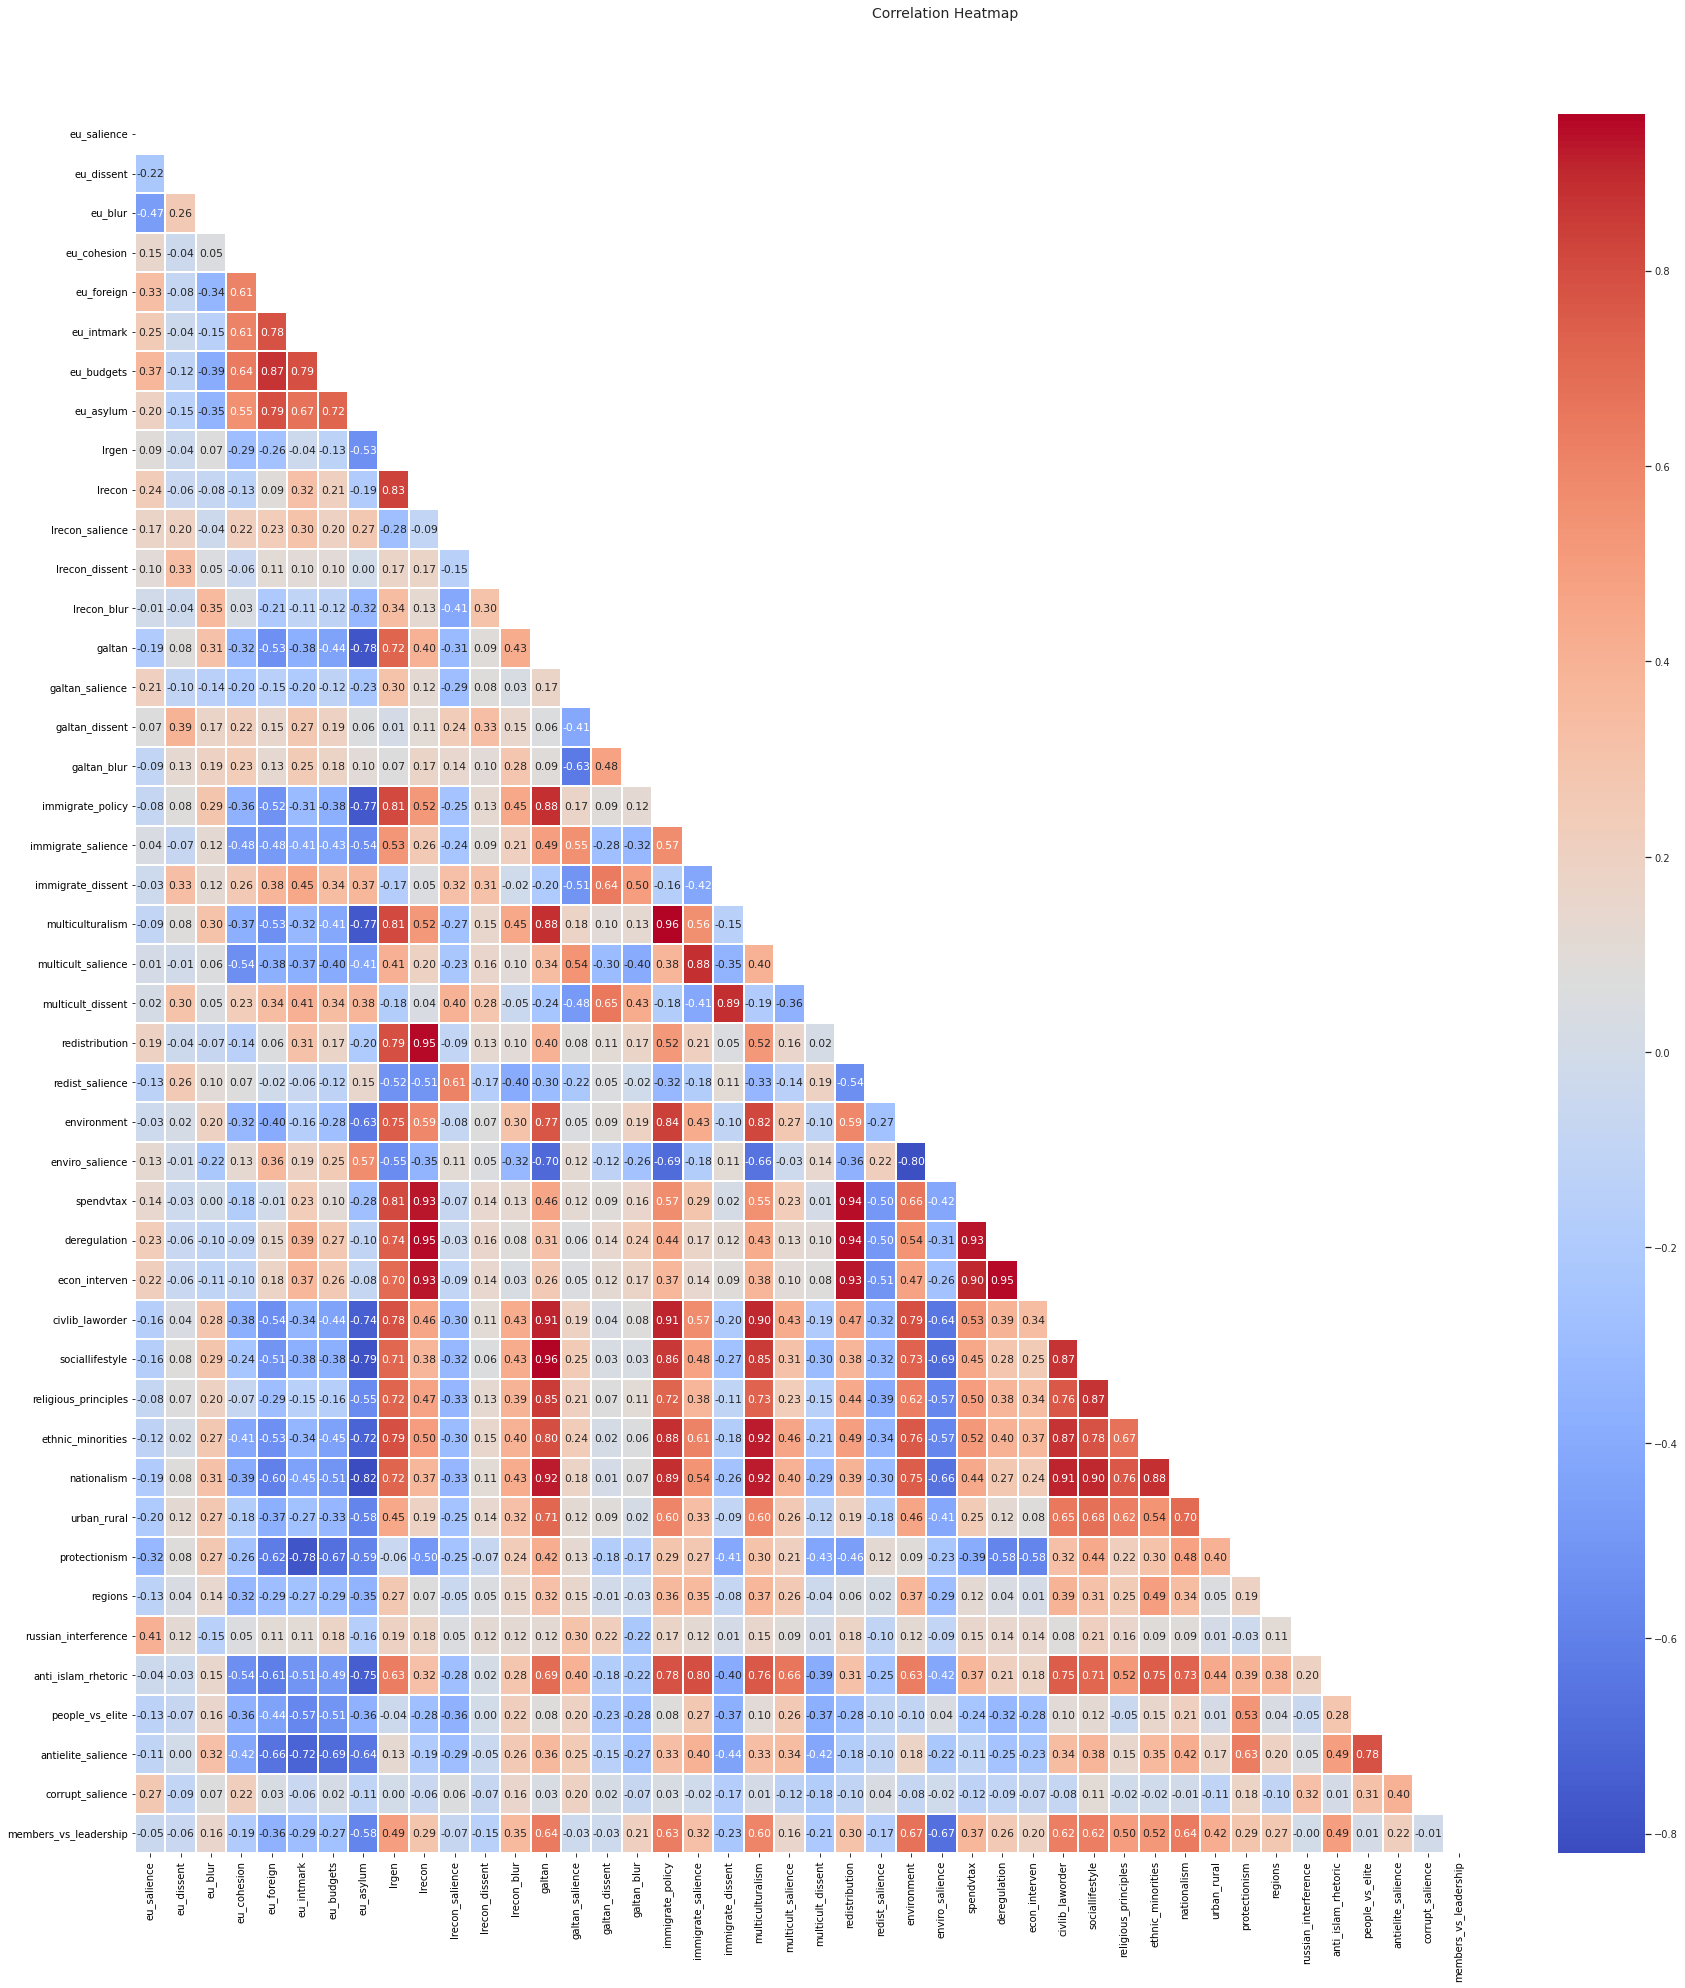

In [22]:
functions.plot_correlation_map(train_set)

### Drop highly correlated variables

In [23]:
train_set_1 = functions.remove_corr_variables(train_set)    

In [24]:
train_set_1.head()

,eastwest,eu_salience,eu_dissent,eu_blur,eu_cohesion,eu_foreign,lrgen,lrecon_salience,lrecon_dissent,lrecon_blur,galtan_salience,galtan_dissent,galtan_blur,immigrate_salience,immigrate_dissent,redist_salience,regions,russian_interference,people_vs_elite,corrupt_salience,members_vs_leadership
0,east,4.272728,2.75,2.166667,6.250,5.444445,2.083333,8.166667,2.2,1.142857,4.000000,2.5,2.750000,4.250000,3.400000,8.166667,6.000000,0.111111,3.363636,1.909091,7.500000
1,east,4.181818,2.50,1.714286,6.000,5.444445,3.083333,7.916666,2.2,1.428572,4.583334,2.5,2.777778,4.500000,4.181818,8.083333,5.333334,0.111111,3.545454,1.636364,6.818182
2,east,4.818182,2.50,1.428572,6.000,5.666666,2.083333,6.250000,3.4,2.000000,6.272728,1.0,1.625000,6.000000,2.000000,7.000000,6.166666,0.111111,5.636363,2.363636,3.909091
3,east,4.818182,2.50,1.285714,5.875,5.666666,2.416667,6.250000,3.0,2.000000,6.416666,1.0,1.666667,5.583334,2.090909,7.000000,6.083334,0.111111,5.636363,2.000000,4.000000
4,east,5.090909,2.00,1.714286,5.500,5.777778,6.500000,8.083333,2.4,1.285714,4.454546,1.5,3.125000,4.666666,4.600000,6.000000,6.416666,0.111111,4.636363,1.636364,7.000000


In [25]:
train_set_1.shape

(247, 21)

#### Eliminating highly correlated variables as a method can help in dimensionality reduction, but it's not sufficient if we want to present the model in 2D space. It's more useful for multivariate regression, where we should select a few statistical significant variables, that are not correlated. In our case we have to choose only one indipendent variable which can explain most of the variance. The next step will be feature selection. It could be done either with random forest or linear regression. 

### 6.1 Estimate the feature importance with Random Forest and select the most important feature.

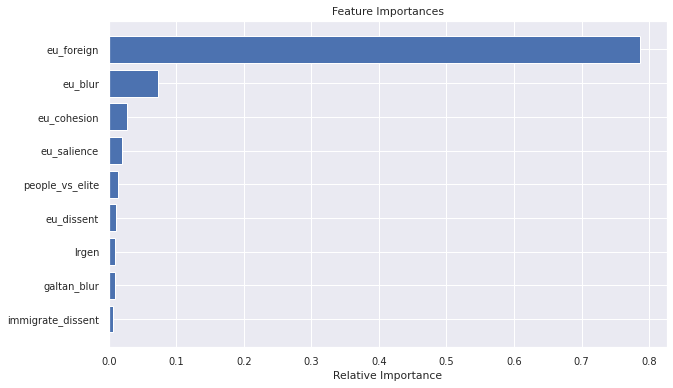

In [26]:
functions.feature_importance(train_set_1.drop('eastwest', axis =1),dependant_variable) 

### 6.2 Make linear regression model with single variable (for all features in the data set run a separate regression) and compare the R2 (goodness of the fit).
#### We are doing single linear regression for every feature/variable separately to find which variable describes best the target variable (explains the most of the variance). Since the variables are running in the regression independently of one another, we don't have colinearity issue and we can check all variables in train_set. (in train_set_1 the highly correlated variables are removed) 
#### It's good to mention here that there are two standard methods for feature selection in linear regression model with ready python packages (Backward Feature Elimination and Forward Feature Selection). They are both based on calculating the coeficients of the variables. 

In [27]:
df_scores, models = functions.linear_model(train_set, dependant_variable)
df_scores

,R2
eu_budgets,0.834406
eu_foreign,0.794365
eu_intmark,0.751349
eu_asylum,0.680059
antielite_salience,0.572093
protectionism,0.504811
eu_cohesion,0.485193
nationalism,0.408486
anti_islam_rhetoric,0.394602
galtan,0.315775


#### We can se that 'eu_budgets' pops up on the top of the list (explains 83,4% of the variance). It's highly correlated with 'eu_foreign',(what is selected as most important feature with random forest) and as such removed from the variables list. However it makes the best fit to the target variable and in two dimensional space is that one variable who can explain most of the variances in the model. 
#### It also brings up to the point that removing correlated variables, could be a tricky task sometimes. This is because of the sequential nature of the python functions, they are unable to consider the state of all the variables holistically. The decision to drop variables happens in order and is final. If we do the feature selection with random forest with complete train set (before being cleaned from highly correlated variables, we will get the same most important feature as with linear regression.

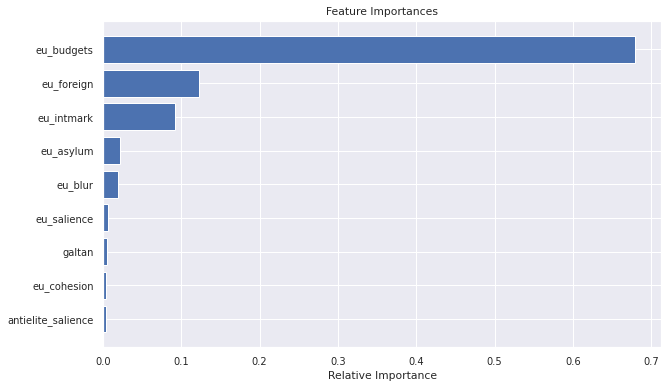

In [28]:
functions.feature_importance(train_set.drop('eastwest', axis =1),dependant_variable) 

#### Generally, correlated and/or collinear (when the association between two variables is linear) features do not affect classification accuracy of the model per se, but it might affect its interpretability, especially it makes hard to interpret the coefficients, and it reduces the power of the model to identify independent variables that are statistically significant. They can contribute to the overfitting as well, what is a trouble if we want to make predictions. So, it's always better to have data set with uncorrelated predictors. 
#### Though in our case both ML gave the same most important feature (eu_budgets), not always feature selection gives the same variable in Random Forest and Linear Regression. For linear regression it is the best fit, while for Random Forest it is how much each feature decreases the weighted impurity in a tree. For regression trees the impurty is variance. So, the variance decrease from each feature can be averaged and the features are ranked according to this measure. 
#### It' good to mention here that there are two standard methods with ready python packages for selecting the most important features with linear regression (Backward Feature Elimination and Forward Feature Selection). They are both based on calculating the coeficients. However colinearity could be a big issue when working with linear regression. In that case it's better to use some linear model with regularization like Ridge or Lasso.   

#### For the purposes of our analysis I'll continue with "eu_position" and "eu_budgets" as two selected features for our 2D space. So, out of 54 explanatory varibales in the beginning in 55 dimensional space we ended up with one explanatory variable in two dimensional space. 

#### EU_POSITION = overall orientation of the party leadership towards European integration in 2019.
#### 1 = Strongly opposed
#### 2 = Opposed
#### 3 = Somewhat opposed
#### 4 = Neutral
#### 5 = Somewhat in favor
#### 6 = In favor
#### 7 = Strongly in favor

#### EU_BUDGETS = position of the party leadership in 2019 on EU authority over economic and budgetary policy.
#### 1 = Strongly opposes
#### 7 = Strongly favors

### 7. Visualize the results¶

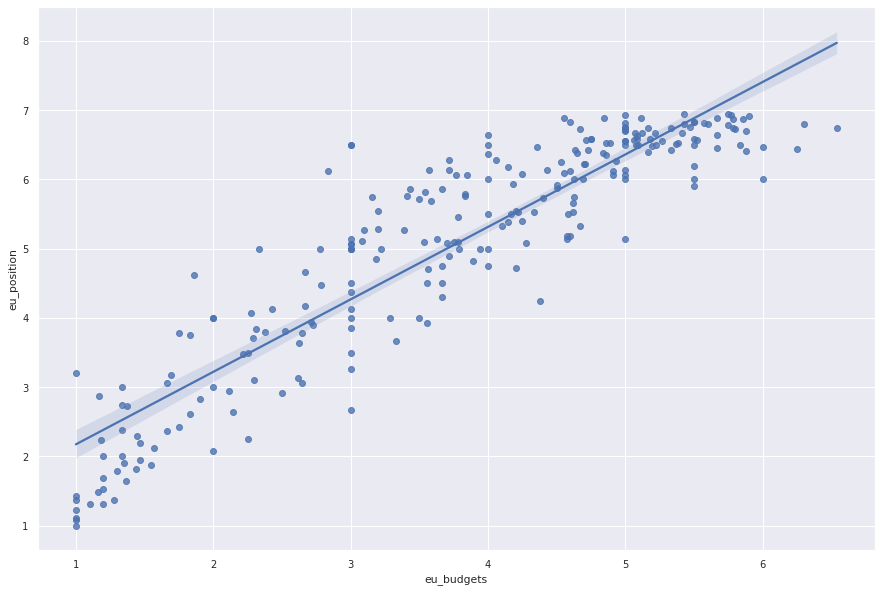

In [29]:
functions.two_D_plot(data, 'eu_position', 'eu_budgets')

#### From the graph we can see that parties which support EU leadership, support budget controll as well. 

#### Plot east and west parties separately to see if there are some differencies. With this we are moving from 2D to mulidimensional space.
#### We can add some other dimensions like 'galtan', (GALTAN = position of the party in 2019 in terms of their views on social and cultural values.“Libertarian” or “postmaterialist” parties favor expanded personal freedoms, for example, abortionrights, divorce, and same-sex marriage. “Traditional” or “authoritarian” parties reject these ideasin favor of order, tradition, and stability, believing that the government should be a firm moralauthority on social and cultural issues) 0 = Libertarian/Postmaterialist, 5 = center, 10 = Traditional/Authoritarian
#### or MULTICULT_DISSENT = degree of dissent on immigrants and asylum seekers issues in 2019. 0 = Party was completely united; 10 = Party was extremely divided.

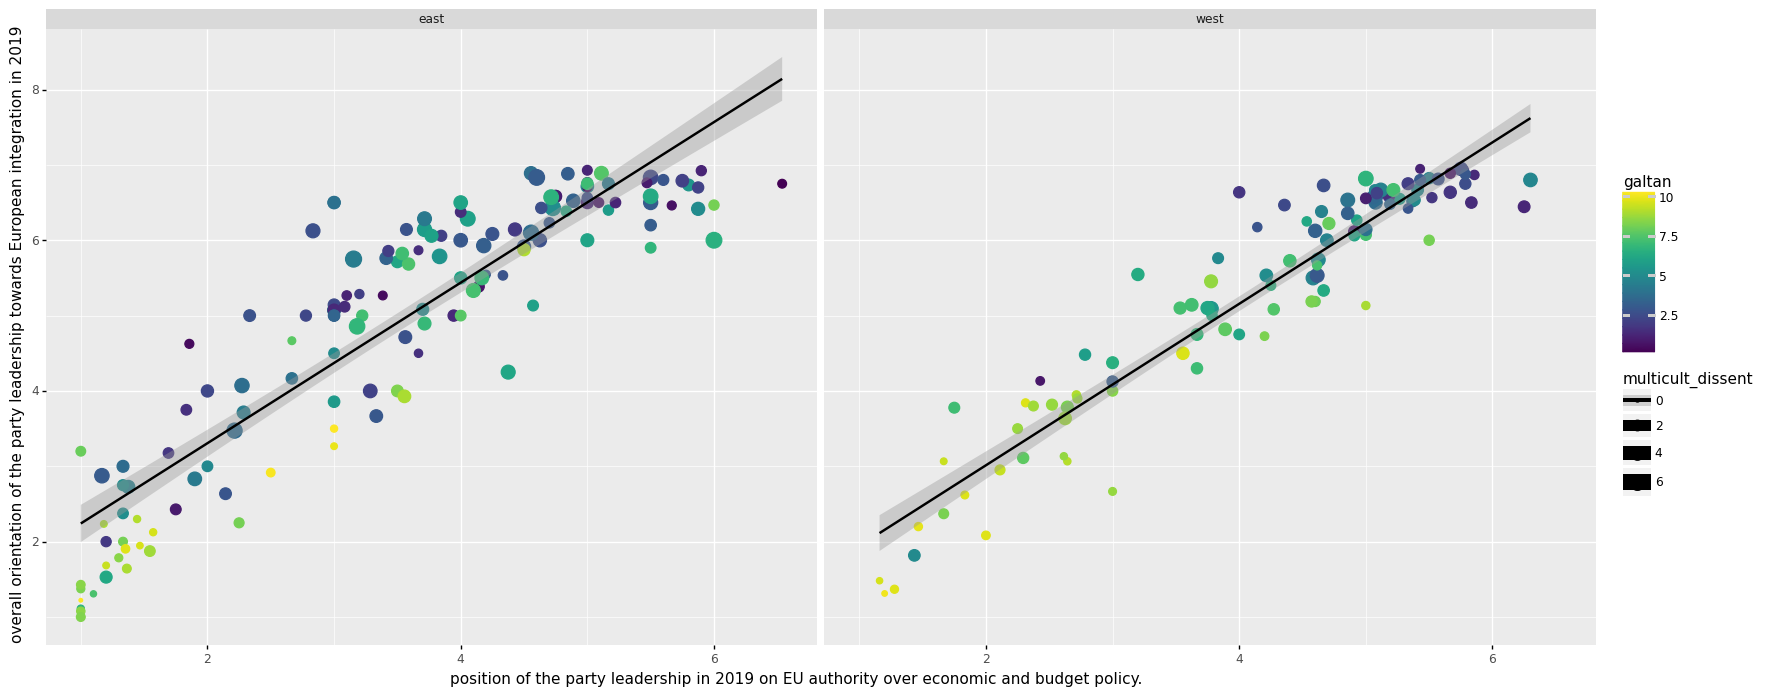

<ggplot: (8760871511447)>

In [30]:
functions.multidimensional_plot(data)

#### We can see that western parties make tighter fit than the eastern. 
#### Colour represents the position of the party on cultural values and light shade (yellow) means traditional, conservative, while dark shade (pink) stands for liberal values. Size represents how united or divided the party was about migration issue. Smaller size shows good agreement within the party.The bigger the dot is, the bigger the division in the party is. 
#### In the western side the situation is more clear. The yellow or light green dots are located at lower right quadrant of the plot. They are conservatives and they oppose EU leadership and budget control. Also light colour parties have smaller dot size, what means they are all united over issues like asylum, migration, multiculturalism. Liberals are on the upper right quadrant of the plot, support EU leadership and budget control, but are more devided about migration issue. 
#### Eastern parties don't show clear pattern. Their support for EU leadership does not depend on whether the party is liberal or conservative. The colours are spread all over the plot, while in the western graph were clearly segmented. Also there are more dark dots with smaller size, what means that progressive parties are more united about multicultularism, unlike their western colleagues. 

## Generate new data points from the fitted distribution
#### We calculate the regression/fitted line and from there take random 10 random samples as new political parties 

In [31]:
model_lr = models['eu_budgets'] 
print(f"intercept: {model_lr.intercept_} , coeficient: {model_lr.coef_}")

intercept: [1.12790569] , coeficient: [[1.04691899]]


#### The value for intercept is 1.12790569 and for coeficient is 1.04691899. Since the eq for the regression line is y = ax + b, where a is the coeficient and b is intercept, we can easilly calculate the same.

In [32]:
y = functions.fit(float(np.asarray(model_lr.coef_)),float(np.asarray(model_lr.intercept_)),train_set['eu_budgets'], model_lr, train_set)

#### Let's check the calculations by ploting the calculated regression line 

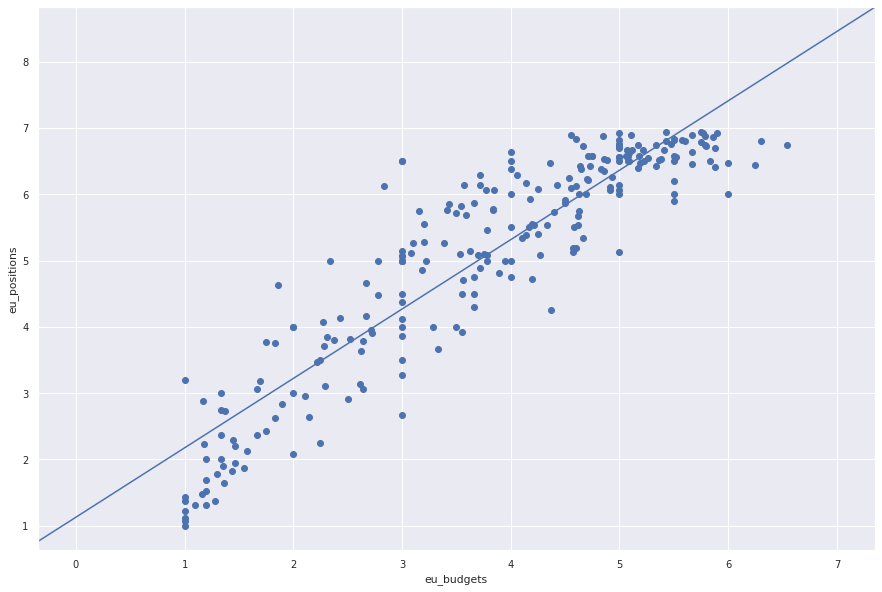

In [33]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(train_set['eu_budgets'], dependant_variable)
plt.axline((0,1.12790569), (7, 7*1.04691899 + 1.12790569))
plt.xlabel('eu_budgets')
plt.ylabel("eu_positions")
plt.show()

#### Take 10 random samples as new political parties

In [34]:
new_parties_df = functions.new_parties(y,float(np.asarray(model_lr.intercept_)),float(np.asarray(model_lr.coef_)))

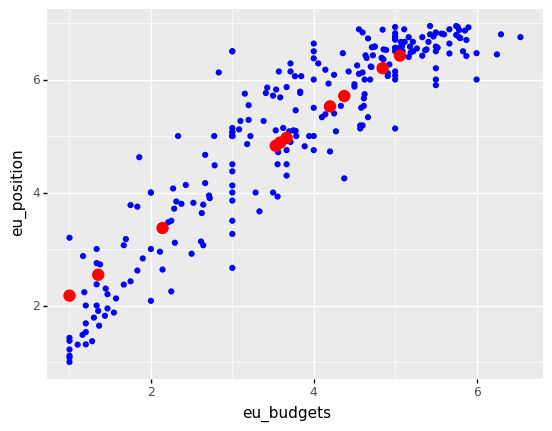

<ggplot: (8760871142979)>

In [35]:
functions.new_parties_plot(data, new_parties_df)

#### New parties are represented with red dots

## For the new political parties, find feature values from the high-dimensional space that map to the sampled 2D points. 
#### Actually we want calculate values for the other features from the high dimensional space based on the model we build. 

In [36]:
feature = new_parties_df['eu_position']
models = functions.linear_model(train_set, dependant_variable)[1]
df_predictions = functions.new_parties_features(feature,models)

In [37]:
df_predictions.shape

(10, 44)

## In the 2D space, paint the area that is valid based on the value bounds of the high dimensional space. I.e., a point that is withinthe bounds in the high dimensional space must be located inside the painted area in the 2D space
#### I think that this point is not relevant for the model I choose. The values of the variables are not changed (they're not rescaled), only their number is reduced. So, they are on same scale in multidimensional and 2D space. 
#### This is applicable for methods like PCA or factor analysis when the original values of variables are changed. 

# APPENDIX
#### This is extra stuff. 
#### Let's check if we can extract additional info by doing this small experiment (combining the methods). Select the top five features and perform PCA. The assumption is that 5 most important features will explain more of the variance than one. They also must be linarly correlated since PCA is build on underlying assamption of linear relationship between the variables. So, in the big data sets if all variables are not linear PCA will not give sensible results. All features are on the same scale so we don't need standardization. 
#### So, let's explain political parties with these features 'eu_budgets','eu_foreign', 'eu_intmark', 'eu_asylum', 'antielite_salience'

In [38]:
x = data[['eu_budgets','eu_foreign', 'eu_intmark', 'eu_asylum', 'antielite_salience']]

In [39]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [40]:
pca.explained_variance_ratio_

array([0.78700402, 0.11908532])

#### The first principle component explains 78,7% of the variance, while the second 11,9% of the variance. In total they make 90% what is better than 83,4% with only one variable, but interpretability is lower.  

#### We can also include eu_position, since PCA doesn't take the target into consideration (only the underalying relationship between the variables).
#### As a target variable we can considered political parties themselves. 

In [41]:
x = data[['eu_position','eu_budgets','eu_foreign', 'eu_intmark', 'eu_asylum', 'antielite_salience']]

In [42]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [43]:
pca.explained_variance_ratio_

array([0.80152066, 0.10990058])

#### More variance explained is shiftted to the first component, since 'eu_position' has high and positive correlation to 'eu_budgets','eu_foreign', 'eu_intmark', and 'eu_asylum', but holds negative correlation to 'antielite_salience'.
#### Now le's remove 'antielite_salience', which has very high but negative relation with the rest of the variables.

In [44]:
x = data[['eu_position','eu_budgets','eu_foreign', 'eu_intmark', 'eu_asylum']]

In [45]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [46]:
pca.explained_variance_ratio_

array([0.85691939, 0.06614143])

#### We can see that now even more weight is given to the first principle component and overal accuracy is a little bit higher 92.3%. Let's now add one more variable 'multiculturalism', to the model that highly negativly correlated to the cluster of positivelly correlated variables. 

In [47]:
x = data[['eu_position','eu_budgets','eu_foreign', 'eu_intmark', 'eu_asylum','multiculturalism']]

In [48]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [49]:
pca.explained_variance_ratio_

array([0.72184963, 0.21030412])

#### The weight is again shifted to the second principle component and overal accuracy of the model is increased for 1%. We can play in this way and explore the relationship between variables and how much they contribute to the model (positivelly correlated variables move the explanation of the model in one direction, while negativelly correlated in another), but applying PCA on a huge data set without knowing anything about the correlation between the variables could be a tricky point. It'll be very hard to interpret the resulst afterword. 